## Decesion Tree

<ol>
    <li><strong>Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features +  preprocessed_essay (TFIDF) + Sentiment scores(preprocessed_essay)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features +  preprocessed_essay (TFIDF W2V) + Sentiment scores(preprocessed_essay)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use gridsearch cv or randomsearch cv)/simple cross validation data(you can write your own for loops refer sample solution)</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>min_sample_split</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>min_sample_split</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
    <li>Once after you plot the confusion matrix with the test data, get all the `false positive data points`
        <ul>
            <li> Plot the WordCloud(https://www.geeksforgeeks.org/generating-word-cloud-python/) with the words of essay text of these `false positive data points`</li>
            <li> Plot the box plot with the `price` of these `false positive data points`</li>
            <li> Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`</li>
        </ul>
        </ul>
    </li>
   

For this task consider **set-1** features.

*  Select all the features which are having non-zero feature importance.You can get the feature importance using  'feature_importances_` 
   (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), discard the all other remaining features and then apply any of the model of you choice i.e. (Dession tree, Logistic Regression, Linear SVM).
*  You need to do hyperparameter tuning corresponding to the model you selected and procedure in step 2 and step 3<br>
  **Note**: when you want to find the feature importance make sure you don't use max_depth parameter keep it None.
  
</ol>

In [ ]:
#https://www.kaggle.com/c/donorschoose-application-screening/notebooks
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/
# some of the sources that I have refered for this assignment and I have include my overall summary at last


%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

#from plotly import plotly
#import plotly.offline as offline
#import plotly.graph_objs as go
#offline.init_notebook_mode()
from collections import Counter

In [ ]:
project_df = pd.read_csv('preprocessed_data.csv', nrows = 50000)
project_df.head()


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [ ]:
print(project_df.shape)
print(project_df['project_is_approved'].value_counts())

(50000, 9)
1    41993
0     8007
Name: project_is_approved, dtype: int64


## Here we are doing nltk sentiment vadar for sentiment intensity analyse 

In [ ]:
import nltk
nltk.download('vader_lexicon')

def nltk_sentiment(sentence):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
from tqdm import tqdm
essay = project_df['essay'].to_list()
essay_sentiment_score = [nltk_sentiment(row) for row in tqdm(essay)]

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [10:09<00:00, 82.00it/s]


In [ ]:
essay_df = pd.DataFrame(essay_sentiment_score)
essay_df.head()

,neg,neu,pos,compound
0,0.013,0.783,0.205,0.9867
1,0.072,0.680,0.248,0.9897
2,0.017,0.721,0.262,0.9860
3,0.030,0.783,0.187,0.9524
4,0.029,0.683,0.288,0.9873


In [ ]:
final_project_df = pd.concat([project_df, essay_df], axis=1)
final_project_df.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,neg,neu,pos,compound
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.783,0.205,0.9867
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,0.072,0.680,0.248,0.9897
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00,0.017,0.721,0.262,0.9860
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04,0.030,0.783,0.187,0.9524
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74,0.029,0.683,0.288,0.9873


In [ ]:
y = final_project_df['project_is_approved'].values
X = final_project_df.drop(['project_is_approved'], axis=1)
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,neg,neu,pos,compound
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.783,0.205,0.9867


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)


In [ ]:
X_train.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,neg,neu,pos,compound
23792,tx,ms,grades_3_5,4,literacy_language,literacy literature_writing,a majority students come low income households...,75.50,0.025,0.766,0.209,0.9756
18364,ny,ms,grades_3_5,2,math_science,appliedsciences,my third grade students lots energy curious so...,658.99,0.031,0.478,0.491,0.9985
16031,dc,ms,grades_9_12,49,literacy_language,literacy literature_writing,i teach high school students urban charter sch...,554.15,0.045,0.786,0.168,0.9683
3887,md,mrs,grades_3_5,22,appliedlearning health_sports,charactereducation teamsports,we big happy family our school home large popu...,409.71,0.000,0.677,0.323,0.9932
24235,il,mrs,grades_prek_2,4,literacy_language,esl literacy,as first graders becoming fluent readers main ...,33.88,0.019,0.670,0.311,0.9902


In [ ]:
X1 = X_train[['price', 'teacher_number_of_previously_posted_projects', 'neg', 'neu', 'pos', 'compound']]
X2 = X_test[['price', 'teacher_number_of_previously_posted_projects', 'neg', 'neu', 'pos', 'compound']]

In [ ]:
x1 = X1.to_numpy()
x2 = X2.to_numpy()

## Set 1 features with TFIDF vectorizer

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)


vectorizer21 = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer21.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer21.transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer21.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)

(33500, 12) (33500,)
(16500, 12) (16500,)
After vectorizations
(33500, 5000) (33500,)
(16500, 5000) (16500,)


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)

vectorizer22 = CountVectorizer()
vectorizer22.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_schoolstate_ohe_1 = vectorizer22.transform(X_train['school_state'].values)
X_test_schoolstate_ohe_1 = vectorizer22.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_schoolstate_ohe_1.shape, y_train.shape)
print(X_test_schoolstate_ohe_1.shape, y_test.shape)
print(vectorizer22.get_feature_names())
print("="*100)

(33500, 12) (33500,)
(16500, 12) (16500,)
After vectorizations
(33500, 51) (33500,)
(16500, 51) (16500,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)

vectorizer23 = CountVectorizer()
vectorizer23.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacherprefix_ohe_1 = vectorizer23.transform(X_train['teacher_prefix'].values)
X_test_teacherprefix_ohe_1 = vectorizer23.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacherprefix_ohe_1.shape, y_train.shape)
print(X_test_teacherprefix_ohe_1.shape, y_test.shape)
print(vectorizer23.get_feature_names())
print("="*100)

(33500, 12) (33500,)
(16500, 12) (16500,)
After vectorizations
(33500, 5) (33500,)
(16500, 5) (16500,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)

vectorizer24 = CountVectorizer()
vectorizer24.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_projectgradecategory_ohe_1 = vectorizer24.transform(X_train['project_grade_category'].values)
X_test_projectgradecategory_ohe_1 = vectorizer24.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_projectgradecategory_ohe_1.shape, y_train.shape)
print(X_test_projectgradecategory_ohe_1.shape, y_test.shape)
print(vectorizer24.get_feature_names())
print("="*100)

(33500, 12) (33500,)
(16500, 12) (16500,)
After vectorizations
(33500, 4) (33500,)
(16500, 4) (16500,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)

vectorizer25 = CountVectorizer()
vectorizer25.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_cleancategories_ohe_1 = vectorizer25.transform(X_train['clean_categories'].values)
X_test_cleancategories_ohe_1 = vectorizer25.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_cleancategories_ohe_1.shape, y_train.shape)
print(X_test_cleancategories_ohe_1.shape, y_test.shape)
print(vectorizer25.get_feature_names())
print("="*100)

(33500, 12) (33500,)
(16500, 12) (16500,)
After vectorizations
(33500, 9) (33500,)
(16500, 9) (16500,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)

vectorizer26 = CountVectorizer()
vectorizer26.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_cleansubcategories_ohe_1 = vectorizer26.transform(X_train['clean_subcategories'].values)
X_test_cleansubcategories_ohe_1 = vectorizer26.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_cleansubcategories_ohe_1.shape, y_train.shape)
print(X_test_cleansubcategories_ohe_1.shape, y_test.shape)
print(vectorizer26.get_feature_names())
print("="*100)

(33500, 12) (33500,)
(16500, 12) (16500,)
After vectorizations
(33500, 30) (33500,)
(16500, 30) (16500,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_1 = hstack((X_train_essay_tfidf, X_train_schoolstate_ohe_1, X_train_teacherprefix_ohe_1, X_train_projectgradecategory_ohe_1, X_train_cleancategories_ohe_1, X_train_cleansubcategories_ohe_1, x1 )).tocsr()
X_te_1 = hstack((X_test_essay_tfidf, X_test_schoolstate_ohe_1, X_test_teacherprefix_ohe_1, X_test_projectgradecategory_ohe_1, X_test_cleancategories_ohe_1, X_test_cleansubcategories_ohe_1, x2)).tocsr()

print("Final Data matrix")
print(X_tr_1.shape, y_train.shape)
print(X_te_1.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 5105) (33500,)
(16500, 5105) (16500,)


In [ ]:
# https://stackoverflow.com/questions/48377296/get-feature-importance-from-gridsearchcv
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier


DT_1 = DecisionTreeClassifier(class_weight = 'balanced')
parameters = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 20, 45, 75, 100, 135, 270, 500]}
clf_1 = GridSearchCV(DT_1, parameters, cv=3, scoring='roc_auc',return_train_score=True)
set1 = clf_1.fit(X_tr_1, y_train)

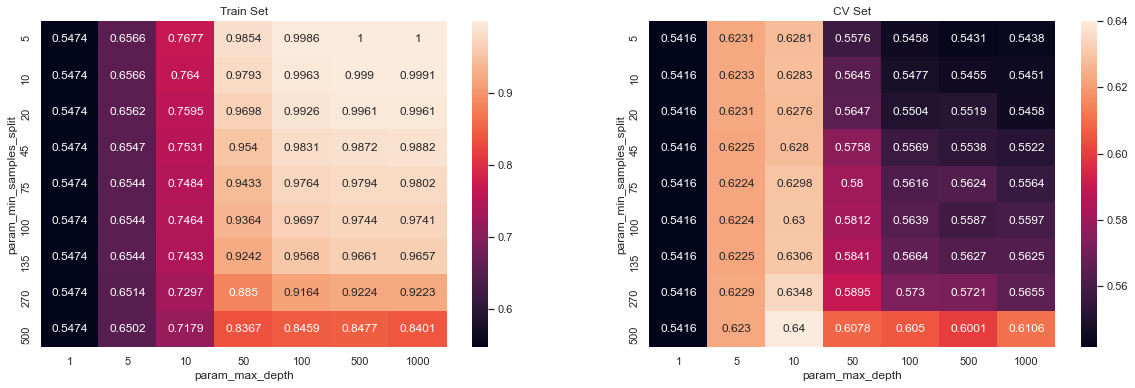

In [ ]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf_1.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [ ]:
print(clf_1.best_estimator_)
print("Using the best parametrs predict the best score for Test", clf_1.score(X_tr_1,y_train))
print("Using the best parametrs predict the best score for Test",clf_1.score(X_te_1,y_test))

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=500)
Using the best parametrs predict the best score for Test 0.715714825885248
Using the best parametrs predict the best score for Test 0.6408811652831263


## Model building with best hyperparameters

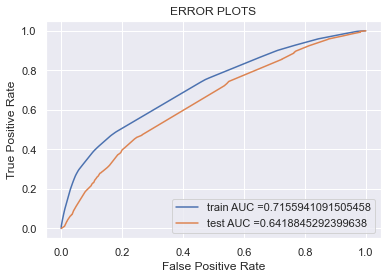

In [ ]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clfV1=DecisionTreeClassifier(class_weight = 'balanced',max_depth=10,min_samples_split=500)
clfV1.fit(X_tr_1, y_train)
y_train_pred1 = clfV1.predict_proba(X_tr_1) [:,1]
y_test_pred1 = clfV1.predict_proba(X_te_1) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()


### Getting confusion matrix beased on best thresold value

In [ ]:
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", np.round(max(tpr*(1-fpr)),2) , "for threshold", np.round(t,2))
    predictions = []
    global predictions1 # make it global
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions1= predictions
    return predictions

the maximum value of tpr*(1-fpr) 0.4 for threshold 0.48
the maximum value of tpr*(1-fpr) 0.35 for threshold 0.48


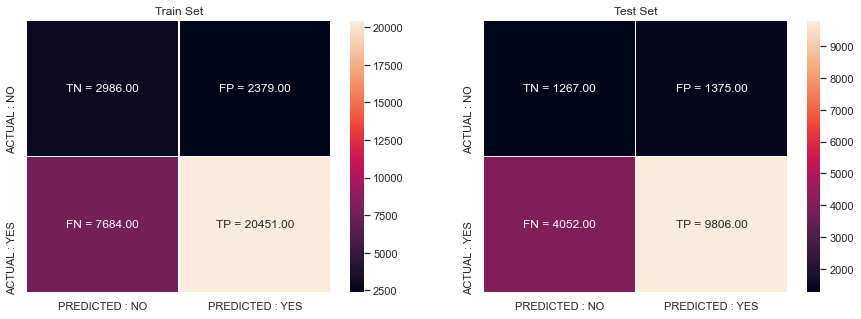

In [ ]:
#https://www.kaggle.com/agungor2/various-confusion-matrix-plots
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

print("="*100)
from sklearn.metrics import confusion_matrix
#best_t1 = find_best_threshold(tr_thresholds1, train_fpr1, train_tpr1)
cm_train1 = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
cm_test1 = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), cm_train1.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),
cm_test1.flatten())])).reshape(2,2)
sns.heatmap(cm_train1, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(cm_test1, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

### Perform analysis on False Positive data 

#### Word cloud on false positive data
#### Box plot on false positive for price feature
#### CDF-PDF plot on false positive for previously posted projects feature

In [ ]:
#https://www.google.com/search?q=geeks+for+geeks+false+positive&rlz=1C1SQJL_enIN849IN849&oq=geeks+for+geeks+false+positive&aqs=chrome..69i57j33l5.6431j0j7&sourceid=chrome&ie=UTF-8
#https://github.com/pskadasi/DecisionTrees_DonorsChoose/blob/master/Copy_of_8_DonorsChoose_DT_(1).ipynb
fpi = []
for i in range(len(y_test)):
    if (y_test[i] == 0) & (predictions1[i] == 1) : #tp = sum((y == 1) & (y_pred == 1))
        fpi.append(i)
fp_essay1 = []
for i in fpi :
    fp_essay1.append(X_test['essay'].values[i])

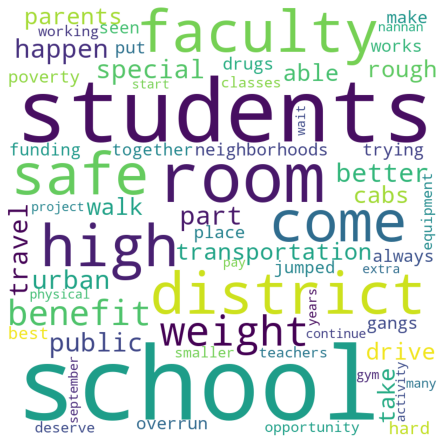

In [ ]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in fp_essay1:
    val = str(val)
    tokens = val.split()
for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
for words in tokens:
    comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [ ]:
# create the DataFrame for Fasle Postive 
# https://www.geeksforgeeks.org/python-pandas-dataframe-filter
cols = X_test.columns
X_test_falsePos1 = pd.DataFrame(columns=cols)
for i in fpi : 
    X_test_falsePos1 = X_test_falsePos1.append(X_test.filter(items=[i], axis=0))

print(X_test_falsePos1.head(10))
print(len(X_test_falsePos1))

    school_state teacher_prefix project_grade_category  \
6             ca            mrs             grades_3_5   
14            sc            mrs             grades_3_5   
30            az             ms          grades_prek_2   
107           fl             ms             grades_6_8   
134           ma             ms          grades_prek_2   
324           in            mrs             grades_3_5   
383           ca             ms             grades_6_8   
404           ok        teacher             grades_3_5   
422           ca            mrs             grades_6_8   
433           nj            mrs          grades_prek_2   

    teacher_number_of_previously_posted_projects  \
6                                              0   
14                                             6   
30                                            58   
107                                            3   
134                                            2   
324                                            6 

<AxesSubplot:ylabel='price'>

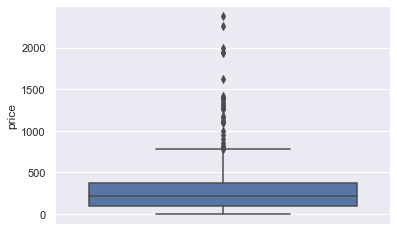

In [ ]:
sns.boxplot(y='price', data=X_test_falsePos1)

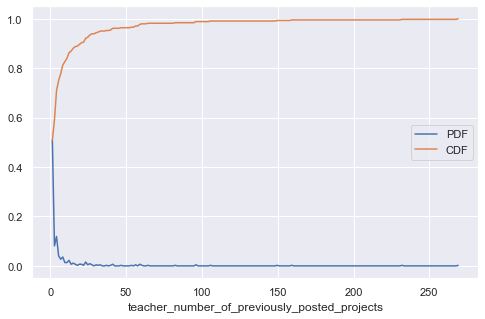

The plot above shows that the projects submetted by the teachers are low and very few have projects with high submission rate 


In [ ]:
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(X_test_falsePos1['teacher_number_of_previously_posted_projects'],
bins='auto', density=True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
pdfP, = plt.plot(bin_edges[1:], pdf)
cdfP, = plt.plot(bin_edges[1:], cdf)
plt.legend([pdfP, cdfP], ["PDF", "CDF"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.show()
print("The plot above shows that the projects submetted by the teachers are low and very few have projects with high submission rate ")

## Getting non zero features and model building on nonzero features only

In [ ]:
set1_feature_importances = clf_1.best_estimator_.feature_importances_ 
set1_feature_importances

array([0.        , 0.        , 0.        , ..., 0.00510783, 0.00577287,
       0.        ])

In [ ]:
non_zero_features = np.where(set1_feature_importances != 0)
non_zero_features

(array([  77,  115,  240,  278,  376,  447,  479,  485,  491,  579,  624,
         657,  928, 1186, 1219, 1234, 1295, 1343, 1346, 1357, 1384, 1391,
        1406, 1525, 1646, 1732, 1891, 1988, 2104, 2114, 2130, 2133, 2228,
        2348, 2416, 2497, 2607, 2612, 2669, 2694, 2742, 2792, 2837, 2904,
        2915, 3005, 3085, 3161, 3165, 3169, 3557, 3588, 3952, 3956, 3957,
        4105, 4297, 4324, 4424, 4502, 4538, 4572, 4664, 4700, 4770, 4810,
        4819, 4834, 4872, 5099, 5100, 5102, 5103], dtype=int64),)

In [ ]:
def selectnonzerofeatures(model, X):
    return X[:,((model.best_estimator_.feature_importances_) != 0)]

In [ ]:

final_x_tr_1 = selectnonzerofeatures(clf_1, X_tr_1)
final_x_te_1 = selectnonzerofeatures(clf_1, X_te_1)

In [ ]:
print(final_x_tr_1.shape)
print(final_x_te_1.shape)

(33500, 73)
(16500, 73)


## Decision Tree on all non zero features

In [ ]:
# https://stackoverflow.com/questions/48377296/get-feature-importance-from-gridsearchcv
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier


DT_nonzero = DecisionTreeClassifier(class_weight = 'balanced')
parameters = {'min_samples_split': [5, 10, 20, 45, 75, 100, 135, 270, 500]}
final_clf_1 = GridSearchCV(DT_nonzero, parameters, cv=3, scoring='roc_auc',return_train_score=True)
set1_nonzero = final_clf_1.fit(final_x_tr_1, y_train)

In [ ]:
print(final_clf_1.best_estimator_)
print("Using the best parametrs predict the best score for Test", final_clf_1.score(final_x_tr_1,y_train))
print("Using the best parametrs predict the best score for Test",final_clf_1.score(final_x_te_1,y_test))

DecisionTreeClassifier(class_weight='balanced', min_samples_split=500)
Using the best parametrs predict the best score for Test 0.7802033035038923
Using the best parametrs predict the best score for Test 0.6353374401261896


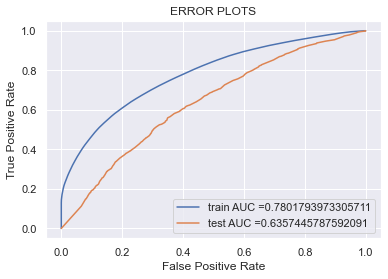

In [ ]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clf1_nonzero=DecisionTreeClassifier(class_weight = 'balanced',min_samples_split=500)
clf1_nonzero.fit(final_x_tr_1, y_train)
y_train_pred_nonzero = clf1_nonzero.predict_proba(final_x_tr_1) [:,1]
y_test_pred_nonzero = clf1_nonzero.predict_proba(final_x_te_1) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred_nonzero)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred_nonzero)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

the maximum value of tpr*(1-fpr) 0.22 for threshold 0.71
the maximum value of tpr*(1-fpr) 0.23 for threshold 0.71


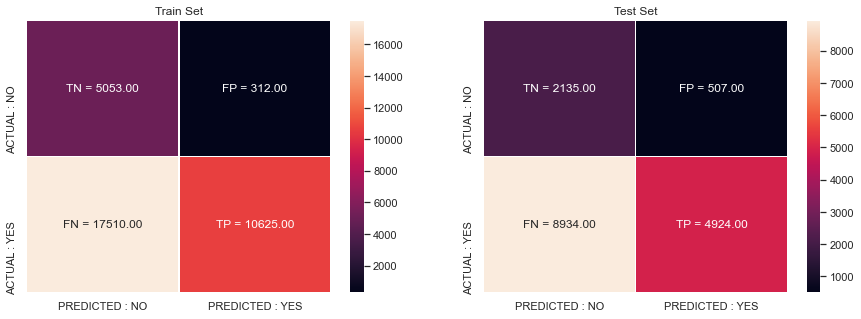

In [ ]:
#https://www.kaggle.com/agungor2/various-confusion-matrix-plots
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

print("="*100)
from sklearn.metrics import confusion_matrix
#best_t1 = find_best_threshold(tr_thresholds1, train_fpr1, train_tpr1)
cm_train1 = confusion_matrix(y_train, predict(y_train_pred_nonzero, tr_thresholds1, train_fpr1, train_tpr1))
cm_test1 = confusion_matrix(y_test, predict(y_test_pred_nonzero, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), cm_train1.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),
cm_test1.flatten())])).reshape(2,2)
sns.heatmap(cm_train1, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(cm_test1, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

## SGDClassifier on all non zero features

In [ ]:
# https://stackoverflow.com/questions/48377296/get-feature-importance-from-gridsearchcv
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

parameters = { "alpha" : [0.0001, 0.001, 0.01, 1, 10, 100, 1000]}

lr = SGDClassifier(max_iter=1000, loss = 'log' )
final_lr = GridSearchCV(lr, param_grid=parameters)

set1_lr = final_lr.fit(final_x_tr_1, y_train)

In [ ]:
print(final_lr.best_estimator_)
print("Using the best parametrs predict the best score for Test", final_lr.score(final_x_tr_1,y_train))
print("Using the best parametrs predict the best score for Test",final_lr.score(final_x_te_1,y_test))

SGDClassifier(alpha=1, loss='log')
Using the best parametrs predict the best score for Test 0.8398507462686567
Using the best parametrs predict the best score for Test 0.8398787878787879


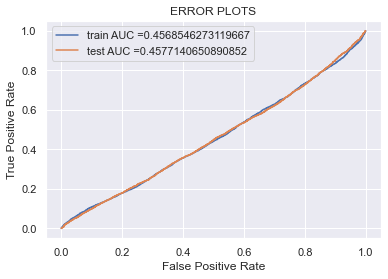

In [ ]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clfV1_lr=SGDClassifier(max_iter=1000, loss = 'log', alpha = 1 )
clfV1_lr.fit(final_x_tr_1, y_train)
y_train_pred1_lr = clfV1_lr.predict_proba(final_x_tr_1) [:,1]
y_test_pred1_lr = clfV1_lr.predict_proba(final_x_te_1) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1_lr)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1_lr)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

the maximum value of tpr*(1-fpr) 0.22 for threshold 0.71
the maximum value of tpr*(1-fpr) 0.23 for threshold 0.71


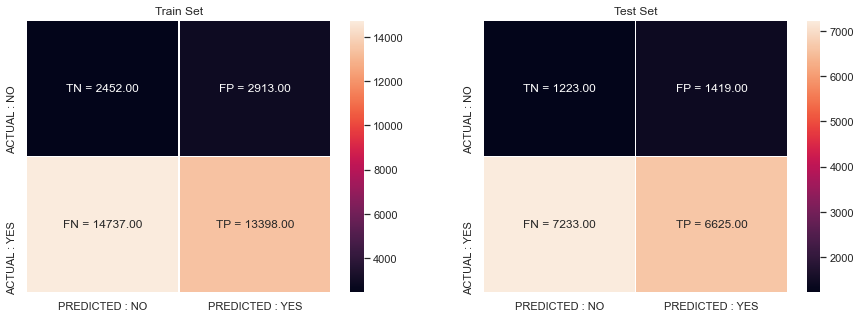

In [ ]:
#https://www.kaggle.com/agungor2/various-confusion-matrix-plots
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

print("="*100)
from sklearn.metrics import confusion_matrix
#best_t1 = find_best_threshold(tr_thresholds1, train_fpr1, train_tpr1)
cm_train1 = confusion_matrix(y_train, predict(y_train_pred1_lr, tr_thresholds1, train_fpr1, train_tpr1))
cm_test1 = confusion_matrix(y_test, predict(y_test_pred1_lr, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), cm_train1.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),
cm_test1.flatten())])).reshape(2,2)
sns.heatmap(cm_train1, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(cm_test1, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

## Simple Logisitc Regression with Regularisor on all non zero features

In [ ]:
from sklearn.linear_model import LogisticRegression

grid = {'C': np.logspace(-3,3,7), 'penalty': ['l1', 'l2']}
# C and penalty are logistic regression regularization parameters
# If C is too small model is underfitted, if C is too big model is overfitted.
# l1 and l2 are regularization loss functions (l1=lasso, l2=ridge)

# Creating the model:
lr = LogisticRegression() 

# Creating GridSearchCV model:
lr_cv = GridSearchCV(lr, grid, cv=10) # Using lr model, grid parameters and cross validation of 10 (10 times of accuracy calculation will be applied) 

# Training the model:
lr_cv.fit(final_x_tr_1, y_train)

print('best paremeters for logistic regression: ', lr_cv.best_params_)
print('best score for logistic regression after grid search cv:', lr_cv.best_score_)

best paremeters for logistic regression:  {'C': 0.001, 'penalty': 'l2'}
best score for logistic regression after grid search cv: 0.8393134328358208


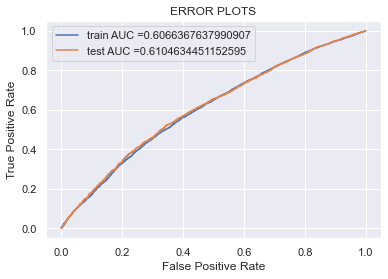

In [ ]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clfV1_slr=LogisticRegression(C= 0.001, penalty= 'l2')
clfV1_slr.fit(final_x_tr_1, y_train)
y_train_pred1_slr = clfV1_slr.predict_proba(final_x_tr_1) [:,1]
y_test_pred1_slr = clfV1_slr.predict_proba(final_x_te_1) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1_slr)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1_slr)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

In [ ]:
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", np.round(max(tpr*(1-fpr)),2) , "for threshold", np.round(t,2))
    predictions = []
    global predictions1 # make it global
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions1= predictions
    return predictions

the maximum value of tpr*(1-fpr) 0.34 for threshold 0.84
the maximum value of tpr*(1-fpr) 0.34 for threshold 0.84


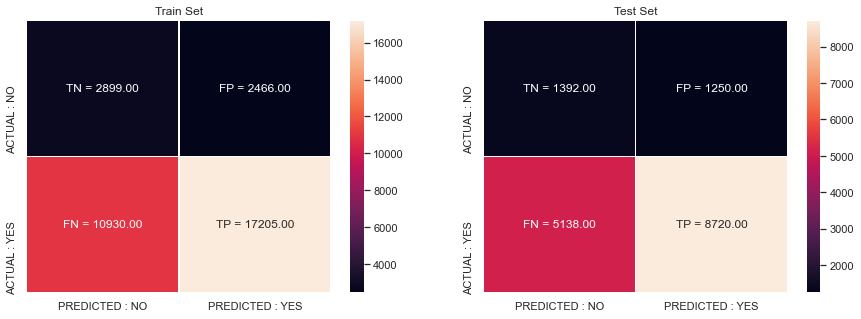

In [ ]:
#https://www.kaggle.com/agungor2/various-confusion-matrix-plots
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

print("="*100)
from sklearn.metrics import confusion_matrix
#best_t1 = find_best_threshold(tr_thresholds1, train_fpr1, train_tpr1)
cm_train1 = confusion_matrix(y_train, predict(y_train_pred1_slr, tr_thresholds1, train_fpr1, train_tpr1))
cm_test1 = confusion_matrix(y_test, predict(y_test_pred1_slr, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), cm_train1.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),
cm_test1.flatten())])).reshape(2,2)
sns.heatmap(cm_train1, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(cm_test1, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

## Set 2 features with TFIDF W2V vectorizer

In [ ]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))
X_train_tfidf_w2v_vectors_essay = np.array(tfidf_w2v_vectors)
print(X_train_tfidf_w2v_vectors_essay.shape, y_train.shape)

100%|█████████████████████████████████████████████████████████████████████████| 33500/33500 [00:01<00:00, 24946.56it/s]

33500
300
(33500, 300) (33500,)


In [ ]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_test['essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))
X_test_tfidf_w2v_vectors_essay = np.array(tfidf_w2v_vectors)
print(X_test_tfidf_w2v_vectors_essay.shape, y_test.shape)

100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 27480.23it/s]


16500
300
(16500, 300) (16500,)


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)

vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_schoolstate_ohe_2 = vectorizer.transform(X_train['school_state'].values)
X_test_schoolstate_ohe_2 = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_schoolstate_ohe_2.shape, y_train.shape)
print(X_test_schoolstate_ohe_2.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

(33500, 12) (33500,)
(16500, 12) (16500,)
After vectorizations
(33500, 51) (33500,)
(16500, 51) (16500,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)

vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacherprefix_ohe_2 = vectorizer.transform(X_train['teacher_prefix'].values)
X_test_teacherprefix_ohe_2 = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacherprefix_ohe_2.shape, y_train.shape)
print(X_test_teacherprefix_ohe_2.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

(33500, 12) (33500,)
(16500, 12) (16500,)
After vectorizations
(33500, 5) (33500,)
(16500, 5) (16500,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)

vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_projectgradecategory_ohe_2 = vectorizer.transform(X_train['project_grade_category'].values)
X_test_projectgradecategory_ohe_2 = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_projectgradecategory_ohe_2.shape, y_train.shape)
print(X_test_projectgradecategory_ohe_2.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

(33500, 12) (33500,)
(16500, 12) (16500,)
After vectorizations
(33500, 4) (33500,)
(16500, 4) (16500,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)

vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_cleancategories_ohe_2 = vectorizer.transform(X_train['clean_categories'].values)
X_test_cleancategories_ohe_2 = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_cleancategories_ohe_2.shape, y_train.shape)
print(X_test_cleancategories_ohe_2.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

(33500, 12) (33500,)
(16500, 12) (16500,)
After vectorizations
(33500, 9) (33500,)
(16500, 9) (16500,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)

vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_cleansubcategories_ohe_2 = vectorizer.transform(X_train['clean_subcategories'].values)
X_test_cleansubcategories_ohe_2 = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_cleansubcategories_ohe_2.shape, y_train.shape)
print(X_test_cleansubcategories_ohe_2.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

(33500, 12) (33500,)
(16500, 12) (16500,)
After vectorizations
(33500, 30) (33500,)
(16500, 30) (16500,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_2 = hstack((X_train_tfidf_w2v_vectors_essay, X_train_schoolstate_ohe_2, X_train_teacherprefix_ohe_2, X_train_projectgradecategory_ohe_2, X_train_cleancategories_ohe_2, X_train_cleansubcategories_ohe_2, x1 )).tocsr()
X_te_2 = hstack((X_test_tfidf_w2v_vectors_essay, X_test_schoolstate_ohe_2, X_test_teacherprefix_ohe_2, X_test_projectgradecategory_ohe_2, X_test_cleancategories_ohe_2, X_test_cleansubcategories_ohe_2, x2)).tocsr()

print("Final Data matrix")
print(X_tr_2.shape, y_train.shape)
print(X_te_2.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 405) (33500,)
(16500, 405) (16500,)


In [ ]:
# https://stackoverflow.com/questions/48377296/get-feature-importance-from-gridsearchcv
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier


DT_2 = DecisionTreeClassifier(class_weight = 'balanced')
parameters = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 20, 45, 75, 100, 135, 270, 500]}
clf_2 = GridSearchCV(DT_2, parameters, cv=3, scoring='roc_auc',return_train_score=True)
set2 = clf_2.fit(X_tr_2, y_train)

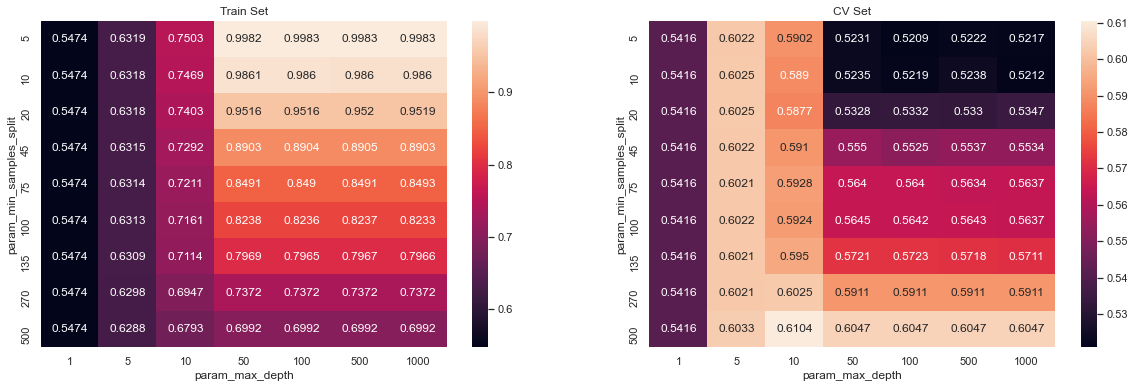

In [ ]:
import seaborn as sns; sns.set()
max_scores2 = pd.DataFrame(clf_2.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores2.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores2.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [ ]:
print(clf_2.best_estimator_)
print("Using the best parametrs predict the best score for Test", clf_2.score(X_tr_2,y_train))
print("Using the best parametrs predict the best score for Test",clf_2.score(X_te_2,y_test))

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=500)
Using the best parametrs predict the best score for Test 0.6736903536089724
Using the best parametrs predict the best score for Test 0.6108052105004923


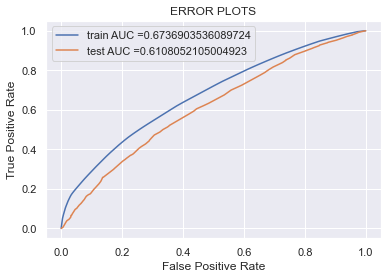

In [ ]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clfV2=DecisionTreeClassifier(class_weight = 'balanced',max_depth=10,min_samples_split=500)
clfV2.fit(X_tr_2, y_train)
y_train_pred2 = clfV2.predict_proba(X_tr_2) [:,1]
y_test_pred2 = clfV2.predict_proba(X_te_2) [:,1]
train_fpr2, train_tpr2, tr_thresholds2 = roc_curve(y_train, y_train_pred2)
test_fpr2, test_tpr2, te_thresholds2 = roc_curve(y_test, y_test_pred2)
plt.plot(train_fpr2, train_tpr2, label="train AUC ="+str(auc(train_fpr2, train_tpr2)))
plt.plot(test_fpr2, test_tpr2, label="test AUC ="+str(auc(test_fpr2, test_tpr2)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

In [ ]:
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", np.round(max(tpr*(1-fpr)),2) , "for threshold", np.round(t,2))
    predictions = []
    global predictions2 # make it global
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions2= predictions
    return predictions

the maximum value of tpr*(1-fpr) 0.38 for threshold 0.45
the maximum value of tpr*(1-fpr) 0.34 for threshold 0.45


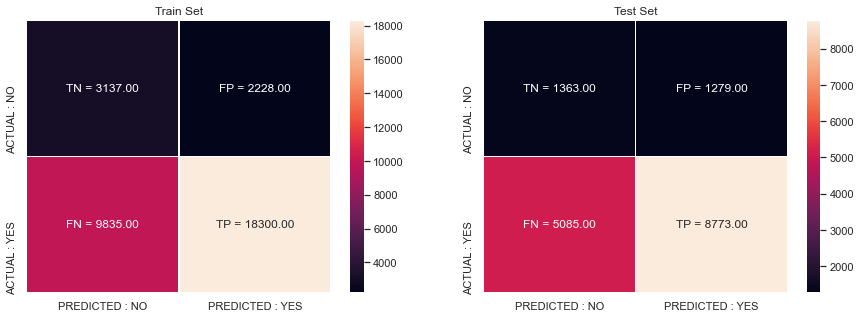

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix

cm_train1 = confusion_matrix(y_train, predict(y_train_pred2, tr_thresholds2, train_fpr2, train_tpr2))
cm_test1 = confusion_matrix(y_test, predict(y_test_pred2, te_thresholds2, test_fpr2, test_tpr2))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), cm_train1.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),
cm_test1.flatten())])).reshape(2,2)
sns.heatmap(cm_train1, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(cm_test1, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

### Perform analysis on False Positive data 

#### Word cloud on false positive data
#### Box plot on false positive for price feature
#### CDF-PDF plot on false positive for previously posted projects feature

In [ ]:
#https://www.google.com/search?q=geeks+for+geeks+false+positive&rlz=1C1SQJL_enIN849IN849&oq=geeks+for+geeks+false+positive&aqs=chrome..69i57j33l5.6431j0j7&sourceid=chrome&ie=UTF-8
#https://github.com/pskadasi/DecisionTrees_DonorsChoose/blob/master/Copy_of_8_DonorsChoose_DT_(1).ipynb
print()
fpi = []
for i in range(len(y_test)):
    if (y_test[i] == 0) & (predictions2[i] == 1) : #tp = sum((y == 1) & (y_pred == 1))
        fpi.append(i)
fp_essay2 = []
for i in fpi :
    fp_essay2.append(X_test['essay'].values[i])

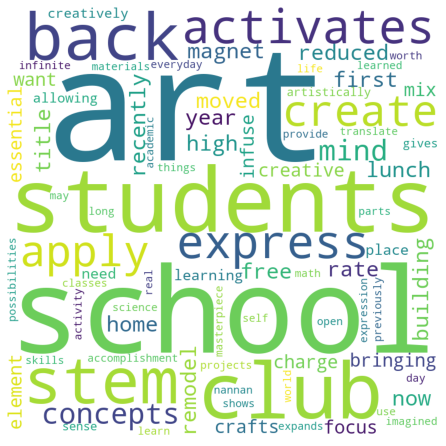

In [ ]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in fp_essay2:
    val = str(val)
    tokens = val.split()
for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
for words in tokens:
    comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [ ]:
# create the DataFrame for Fasle Postive 
# https://www.geeksforgeeks.org/python-pandas-dataframe-filter
cols = X_test.columns
X_test_falsePos2 = pd.DataFrame(columns=cols)
for i in fpi : 
    X_test_falsePos2 = X_test_falsePos2.append(X_test.filter(items=[i], axis=0))

print(X_test_falsePos2.head(10))
print(len(X_test_falsePos2))

    school_state teacher_prefix project_grade_category  \
6             ca            mrs             grades_3_5   
40            nc            mrs             grades_6_8   
98            ct             mr             grades_6_8   
107           fl             ms             grades_6_8   
134           ma             ms          grades_prek_2   
159           ca            mrs          grades_prek_2   
186           ca             ms             grades_3_5   
191           ut             ms             grades_3_5   
324           in            mrs             grades_3_5   
332           mo            mrs             grades_3_5   

    teacher_number_of_previously_posted_projects  \
6                                              0   
40                                             6   
98                                             5   
107                                            3   
134                                            2   
159                                            0 

<AxesSubplot:ylabel='price'>

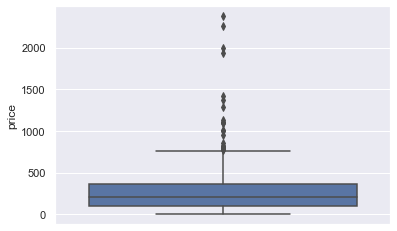

In [ ]:
sns.boxplot(y='price', data=X_test_falsePos2)

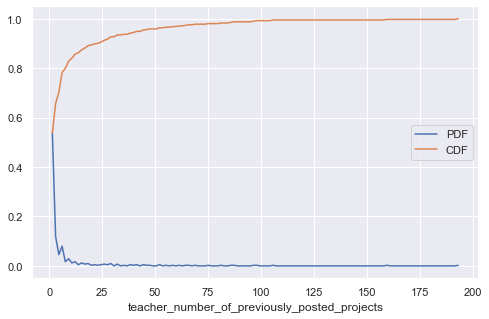

The plot above shows that the projects submetted by the teachers are low and very few have projects with high submission rate 


In [ ]:
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(X_test_falsePos2['teacher_number_of_previously_posted_projects'],
bins='auto', density=True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
pdfP, = plt.plot(bin_edges[1:], pdf)
cdfP, = plt.plot(bin_edges[1:], cdf)
plt.legend([pdfP, cdfP], ["PDF", "CDF"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.show()
print("The plot above shows that the projects submetted by the teachers are low and very few have projects with high submission rate ")

### Summary Table of Decision Tree model on varius Vectorizer with Results

In [ ]:
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= (" Vectorizer ", " Max_depth ", " min_sample_split "," Test -AUC " ,)
tb.add_row([" TFIDF ", 10, 500, 0.64]) #'max_depth': [1, 2, 3], 'n_estimators': [50, 100, 150]
tb.add_row([" TF IDF W2V ", 10, 500, 0.61 ])

print(tb.get_string(titles = "DecisionTress - Observations"))

+--------------+-------------+--------------------+-------------+
|  Vectorizer  |  Max_depth  |  min_sample_split  |  Test -AUC  |
+--------------+-------------+--------------------+-------------+
|    TFIDF     |      10     |        500         |     0.64    |
|  TF IDF W2V  |      10     |        500         |     0.61    |
+--------------+-------------+--------------------+-------------+


### Apply final mdeol on set1 features for only nonzero features 

#### Here I have build Decision Tree, SGDClassifier and Simple Logistic Regression

In [ ]:
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= (" Model ", " Parameter_1 ", " Parameter_2 "," Test -AUC " ,)
tb.add_row([" DecisionTress ", 'not given', 500, 0.63]) #'max_depth': [1, 2, 3], 'n_estimators': [50, 100, 150]
tb.add_row([" SGDClassifier ", "alpha =1", "loss=log loss", 0.45 ])
tb.add_row([" Simple Logisitc Regression ", "alpha=0.001", "regularisor=l2", 0.61 ])

print(tb.get_string(titles = "Different Model on Non-zero features - Observations"))

+------------------------------+---------------+----------------+-------------+
|            Model             |  Parameter_1  |  Parameter_2   |  Test -AUC  |
+------------------------------+---------------+----------------+-------------+
|        DecisionTress         |   not given   |      500       |     0.63    |
|        SGDClassifier         |    alpha =1   | loss=log loss  |     0.45    |
|  Simple Logisitc Regression  |  alpha=0.001  | regularisor=l2 |     0.61    |
+------------------------------+---------------+----------------+-------------+


# Observation of Decision Tree model buildling on DonorsChoose

1) we transform our essay into sentiment score so that we can see how much our sentence is positive, negative, neutral (ration) (all three sum to 1) it means it gives values how much oot 100% sentence is positive, negative and neutral whereas compound gives us values between -1 to 1, if value towards 1 then it is positive and value towards -1 it is negative

2) fit and transform: so we only fit on training data because we use fit_transform() on the train data so that we learn the parameters of scaling on the train data and in the same time we scale the train data. We only use transform() on the test data because we use the scaling paramaters learned on the train data to scale the test data.

3) probability score to find AUC: here we use AUC as metric so that we need probability score to get AUC score and we care about positive class so that we use x_train [:,1] in the code will give you the probabilities of getting the output as 1. If you replace 1 with 0 in the above code, you will only get the probabilities of getting the output as 0. So that here we use 1 because we want to get those probabilti values which gives us as output 1 positive class

4) AUC interpretation: Auc gives us probabilt score let's say 0.70 which means 70% of chances that out model can classify in between positive and negative class but in our case we only use probability for class 1 

5) After computing confusion metrix, we have asked to do some calculation on false positive class. Now as we know interpretation of type 1 and type 2 error can change as per problem for example cancer case study, false positive as it predict cancer but it was not cancer while false negative, it predicts no cancer but it was cancer so in that case false negative is more dangor then false positive. However, in our case false positive means it predicts gives fund but it was not actually, and false negative means it predicts no funding but it was yes funcding so here false positive is more important than false negative as we are giving funds to those projects which are actually not important. . 

6) Flase negative in interpretation on wordcloud, previously posted projects and price: here we want to see that in what cases where we get false postitve values so that we can interpret our model. From, word cloud, we can say that thee are words which is responsible to get false positive values. For price feature, we want box plot so first we create dataframe of false positive points and then plot box plot of price data so that we can see in which price values we get false positive values. From cdf-pdf plot of previously posted features, we can interpret that there ara 90% chances of false positive when we have previously posted projects number is <= 40. while pdf says 50% false positive data points has only 5 previously posted project num while there are majority very few number of previously projects submitted. 

# GBDT model building on DonorsChoose

1) GBDT model building we have changed calculation of categorical features rather than tfidf we have used response coding approach the key difference is when we apply response coding we limit our dimension while with TFIDF or other vectorizer dimensions increases 

2) GBDT is faster than normal decison tree as we have used XGBoost implementation and XGBoost internally use parallel computation despite of model's sequencial calculation 

3) GBDT works faily well with TFIDf and response coding it gives aroung 0.73 AUC score 

# Naive Bayes model building on DonorsChoose

1) Naive Bayes works well for text data and categorical data while numerical data, data has to be gusssian distributed though we can use gaussinNB model for it but typically Naive bayes works well for text and categorical data.

2) In this case study, we apply simple BOW and TFIDF for NB model building and we have got 0.70 AUC score for BOW implementation. 

3) Also we get high probability features for both positive class and negative class classification so that we can interpreat model for further decision making 

# Final conclusion

* We can go with GBDT as it gives higher AUC score and faster to train and we can interpreat the model however if we are after simple model then Naive Bayes will be the choic which is works faily well for small dataset, faster to tarin and easily interpreatbel with probabiltiy score. 